# Credit Card Fraud Detection

![alt text](Images/capa.png)

## Introduction

With the advancement of Internet and the populatization of smartphones, more people use their credit cards to make purchases in online stores, and applications.

In a scenario like this, it is unfortunalety to be expected that some malicious people will look for ways to defraud credit cards and make purchases in the name and with money of other people.

To prevent customers from being charged for purchases that were not made by them, it is very important that banks and credit card companies are able to recognize when a given transaction is the result of fraud or not.

In this project, I will use machine learning algorithms to train a predictive model that is capable of learning and detecting when a transaction is fraudulent or not.

## Dataset Overview:

The dataset contains **30,000 rows** and **25 columns**, comprising a mix of transaction, customer, and merchant details. It is primarily intended for fraud detection analysis, leveraging features like transaction timestamps, geographic data, demographic information, and other transaction-related attributes.

In [3]:
# Import Libs

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import collections

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Load Data
df = pd.read_csv('Data/data.csv')
df.head()

,index,trans_date_trans_time,cc_num,device_os,merchant,amt,trans_num,unix_time,is_fraud,category,merch_lat,merch_long,merchant_id,first,last,gender,street,city,zip,job,dob,lat,long,city_pop,state
0,5381,2023-01-01 00:39:03,2801374844713453,NaN,Merchant_85,252.75,TRANS_662964,1672533543,0,NaN,NaN,76.433212,85.0,Jane,Smith,F,1st Ave,Chicago,NaN,NaN,2002-10-12,41.8781,-87.6298,2716000.0,IL
1,4008,2023-01-01 01:16:08,3460245159749480,NaN,Merchant_23,340.17,TRANS_134939,1672535768,0,Entertainment,27.177588,-64.857435,23.0,Alice,Wilson,M,Broadway,New York,90146.0,Nurse,2001-12-23,40.7128,-74.0060,8419600.0,NY
2,1221,2023-01-01 01:24:28,7308701990157768,macOS,Merchant_70,76.38,TRANS_258923,1672536268,0,Electronics,31.730070,-67.777407,70.0,Bob,Clark,M,Broadway,Phoenix,36374.0,Doctor,1978-12-13,33.4484,-112.0740,1680992.0,AZ
3,9609,2023-01-01 02:06:57,8454886440761098,X11,Merchant_33,368.88,TRANS_226814,1672538817,0,Electronics,-5.005953,146.873847,33.0,Mike,Brown,F,2nd Ave,Phoenix,34323.0,Teacher,1965-04-21,33.4484,-112.0740,1680992.0,AZ
4,5689,2023-01-01 02:10:54,6350332939133843,NaN,Merchant_90,323.32,TRANS_668449,1672539054,0,Groceries,79.065894,40.668693,90.0,Mike,Williams,F,Maple St,New York,77743.0,Nurse,1997-05-17,40.7128,-74.0060,8419600.0,NY


In [4]:
df.describe()

,index,cc_num,amt,unix_time,is_fraud,merch_lat,merch_long,merchant_id,zip,lat,long,city_pop
count,30000.00000,3.000000e+04,29900.000000,3.000000e+04,30000.000000,29401.000000,29990.000000,29990.000000,29784.000000,10020.000000,10020.000000,1.002000e+04
mean,14994.93820,5.638691e+15,250.063287,1.705650e+09,0.019033,2.990787,-7.727705,50.446215,58070.908944,35.726876,-98.630250,3.704410e+06
std,8664.71394,2.743709e+15,144.106058,1.530499e+07,0.136644,55.651821,103.254575,28.939210,24749.348964,4.531306,15.963517,2.323382e+06
min,0.00000,1.001432e+15,1.010000,1.672534e+09,0.000000,-88.616543,-178.256215,1.000000,10008.000000,29.760400,-118.243700,1.680992e+06
25%,7478.75000,3.256119e+15,125.235000,1.696269e+09,0.000000,-46.105529,-101.993026,25.000000,39192.000000,33.448400,-112.074000,2.328000e+06
50%,14999.50000,5.491563e+15,249.625000,1.706376e+09,0.000000,0.067189,-16.648430,50.000000,58583.000000,34.052200,-95.369800,2.716000e+06
75%,22499.25000,8.149117e+15,375.242500,1.718328e+09,0.000000,49.823343,90.051574,76.000000,78251.000000,40.712800,-87.629800,3.979576e+06
max,29999.00000,1.000000e+16,499.970000,1.730124e+09,1.000000,89.069132,178.663853,100.000000,99994.000000,41.878100,-74.006000,8.419600e+06


In [5]:
df.isnull().sum().max()

19980

In [6]:
df.columns

Index(['index', 'trans_date_trans_time', 'cc_num', 'device_os', 'merchant',
       'amt', 'trans_num', 'unix_time', 'is_fraud', 'category', 'merch_lat',
       'merch_long', 'merchant_id', 'first', 'last', 'gender', 'street',
       'city', 'zip', 'job', 'dob', 'lat', 'long', 'city_pop', 'state'],
      dtype='object')

In [8]:
print('No Frauds', round(df['is_fraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['is_fraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 98.1 % of the dataset
Frauds 1.9 % of the dataset


Our Original Dataset is very imbalanced! Most of the transactions are not fraudulent. Using this dataframe as the base for our predictive models and analysis would lead to a model that is not able to detect frauds and our algorithms will probably overfit since it will be biased towards the majority class.

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

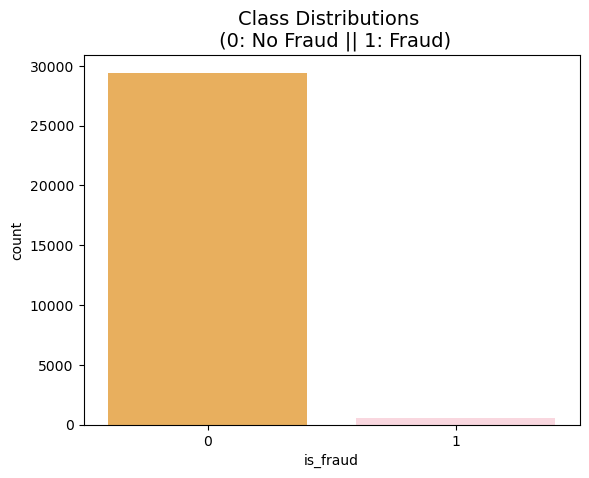

In [17]:
colors = [
    "#ffb347", "#ffd1dc", "#b19cd9", "#ffcccb", "#fdfd96", 
    "#cfcfc4", "#ffb6c1", "#c3b091", "#d8bfd8", "#add8e6",
    "#90ee90", "#f08080", "#fafad2", "#dda0dd", "#ffc0cb",
    "#ffdab9", "#e6e6fa", "#98fb98", "#ffe4e1", "#afeeee",
    "#f5deb3", "#ffdead", "#e0ffff", "#d3ffce", "#ff69b4"
]

sns.countplot(x='is_fraud', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

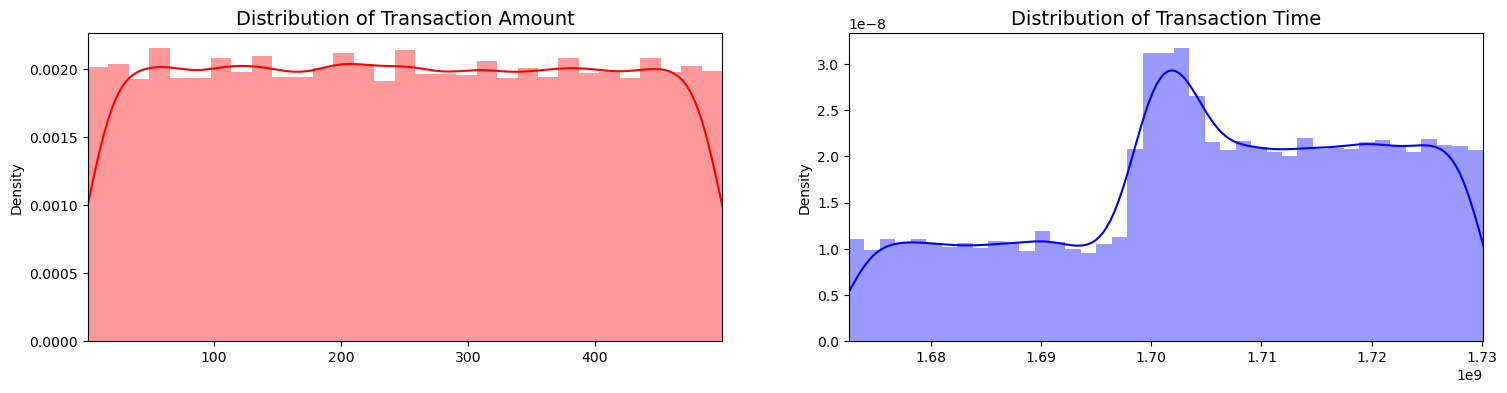

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amt'].values
time_val = df['unix_time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

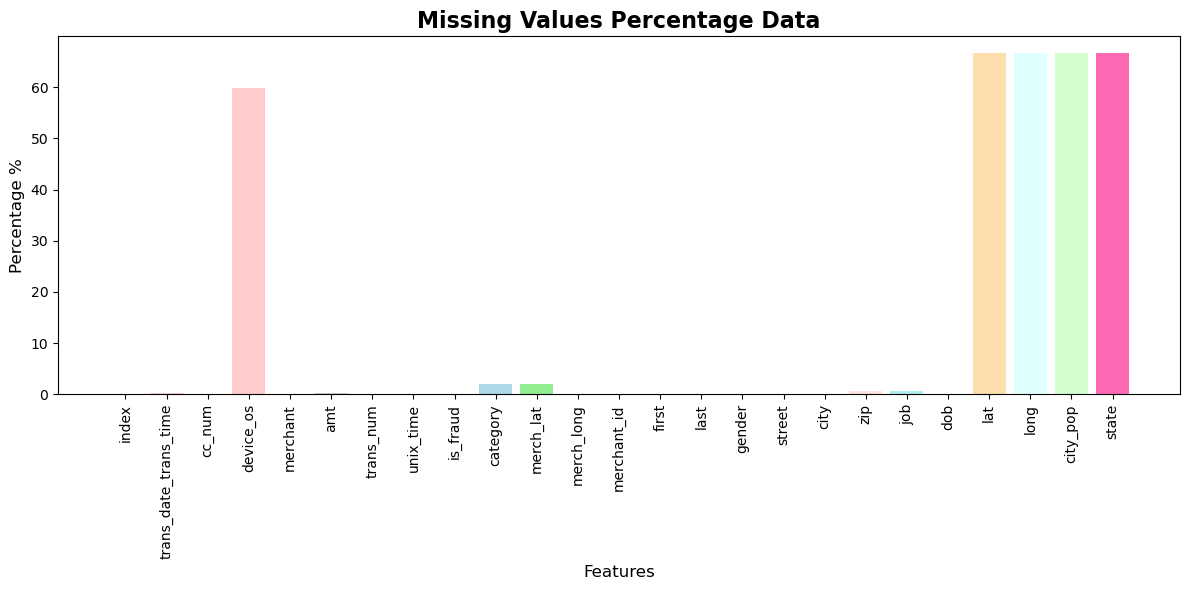

In [19]:
# Plot Missing Values
missing_values = (df.isnull().sum() / len(df)) * 100
plt.figure(figsize=(12, 6))
plt.bar(missing_values.index, missing_values.values, color=colors)
plt.title(f"Missing Values Percentage Data", fontsize=16, fontweight="bold")
plt.ylabel("Percentage %", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.tight_layout()
plt.show()

In [20]:
columns_to_remove = columns_to_remove = ['first', 'last', 'merchant', 'index', 'trans_num', 'merchant_id', 'lat', 'long', 'device_os', 'city_pop', 'state']
df = df.drop(columns=columns_to_remove, errors='ignore')